In [1]:
%load_ext autoreload
%autoreload 2

# Orthogonality of our sponge circuit components to sRNA network

The circuit is composed of a synthetic sRNA and two fluorescent proteins mRNA's, cyRFP and EGFP.

## Imports

In [2]:
import os
import pandas as pd
import re
import logging 

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.IntaRNA.bin.copomus.IntaRNA import IntaRNA
from synbio_morpher.srv.parameter_prediction.simulator import process_raw_stdout
from synbio_morpher.utils.circuit.common.config_setup import retrieve_default_args, load_simulator_kwargs
from synbio_morpher.utils.common.setup import prepare_config, expand_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA, write_fasta_file
from synbio_morpher.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs
from synbio_morpher.utils.misc.string_handling import string_to_tuple_list
from synbio_morpher.utils.misc.type_handling import get_nth_elements, flatten_listlike

from subprocess import Popen, PIPE, run
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax



# Load data

Load the sequences for EGFP and cyRFP, along with synthetic ChiX and the other sRNA's.

In [3]:
fn_tus = os.path.join('..', 'data', 'sRNA', 'EcoCyc', 'EcoCyc_TUs_DH10B.csv')
fn_srnas = os.path.join('..', 'data', 'sRNA', 'EcoCyc', 'EcoCyc_regulatory_RNAs_DH10B.csv')
fn_merged = os.path.join('..', 'data', 'sRNA', 'merged_EcoCyc_RNAInter_sRNATarBase.csv')
fn_inter = os.path.join('..', 'data', 'sRNA', 'merged_inter.csv')
d_tus = pd.read_csv(fn_tus, index_col=0)
d_srnas = pd.read_csv(fn_srnas, index_col=0)
d_merged = pd.read_csv(fn_merged, index_col=0)
d_inter = pd.read_csv(fn_inter, index_col=0)

fn_fps = 'data/fps.fasta'
fn_muts = 'data/scott_mutations.fasta'
muts = load_seq_from_FASTA(fn_muts, as_type='dict')
fps = load_seq_from_FASTA(fn_fps, as_type='dict')

## Get new syntheses

In [4]:
sdir = 'February 2024 synthesis'

all_synths = {}
for f in os.listdir(sdir): 
    syn = load_seq_from_FASTA(os.path.join(sdir, f), as_type='dict')
    all_synths.update(syn)
    
all_synths

{'double_seed_NT_mScarlet-I': 'GGTCTCAGTACAGCGCTCAACGGGTGTGCTTCCCGTTCTGATGAGTCCGTGAGGACGAAAGCGCCTCTACAAATAATTTTGTTTAAacttcctgagccggaacgaaaagttttatcggaatgcgtgttctgatgggcttttggcttacggtATAAGGAGTCCGGTGTAGCGAAAGcaattggtctgcgattcagaccacggtagcgagactaccctttttcCACTGCCTCGCCCTTGCTCACCAtacatttaccctGAAACATTTCGTCCATCTCTAAGAatagtgattaatgtagcaccgccatattgcggtgcttttttttTCGAAGAGACC',
 'sRNA_mScarlet-I_alternative': 'ACAGATCGTCAAGATTAGAAAACGGTAGCAGCATTATCGGAGGTTCTCTAACTAGTGGTCTCAGTACAGCGCTCAACGGGTGTGCTTCCCGTTCTGATGAGTCCGTGAGGACGAAAGCGCCTCTACAAATAATTTTGTTTAAACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCCATGTGCACCTTGAACCGGCCAATAGCGATATTGGCCATTTTTTTTCGAAGAGACCATGGATAGCCGTGTCTTCACTGTGCTGCGGCTACCCATCGCCTGAAAACCAGTTGG',
 'MicC': 'TCTACGCAGCGACATGTTTATTAACAGTTGTCTGGCAGCACAAAACTGGTCTCAGTACAGTAGTCACCGGCTGTGCTTGCCGGTCTGATGAGCCTGTGAAGGCGAAACTACCTCTACAAATAATTTTGTTTAACTCGAGAAAAAAAGCCCGGACGACTGTTCGGGCTTGTCTTTTTATATGTTGGAAAATCAGTGGCAATGCAATGGCCCAACAGAAAATGCGTAAAGGAGAAGAACTTTTCCATAAGAGACCTTTACCATGGTCGTAGAAGCCCCCCAGAGTTAG

## Select sRNAs from database

In [5]:
to_remove = ['e14 prophage; ', 'Qin prophage; ', 'Rac prophage; ', 
             'putative antisense regulatory RNA ', 'small regulatory RNA antitoxin ', 
             'putative antitoxin ', 'antisense regulatory RNA ', 'small antisense RNA ',
             'antitoxin ', 'small regulatory RNA ', 'small RNA ', ' small regulatory RNA']

for r in to_remove:
    d_srnas['Common-Name'] = d_srnas['Common-Name'].str.replace(r, '')
    
d_srnas['Common-Name'] = d_srnas['Common-Name'].str.replace(' ', '_')
    

In [6]:
d_srnas['Common-Name'].unique()

array(['6S_RNA', 'RdlD', 'arfA-derived', 'C0293', 'RdlB', 'RdlC',
       'putative_SokB', 'DicF', 'RalA', 'aMEF', 'AsCRP', 'AsflhD',
       'AsphoP', 'StfZ', "3'ETSleuZ", 'AgrB', 'SibC', 'SokC', 'SymR',
       'ArcZ', 'ArrS', 'AspX', 'AzuR', 'ChiX', 'ChiZ', 'CpxQ', 'CsrB',
       'CsrC', 'CyaR', 'DsrA', 'FimR2', 'FnrS', 'FtsO', 'GadF', 'GadY',
       'GcvB', 'GlmY', 'GlmZ', 'GlnZ', 'IspZ', 'IstR-1', 'MalH', 'McaS',
       'MgrR', 'MicA', 'MicC', 'MicF', 'MicL-S', 'Och5', 'OhsC', 'OmrA',
       'OmrB', 'OxyS', 'PspH', 'RbsZ', 'RirA', 'RprA', 'RseX', 'RybB',
       'RydB', 'RydC', 'RyfA', 'RyfD', 'RyhB', 'SdhX', 'SdsN', 'SdsR',
       'SgrS', 'Spot_42', 'SraG', 'SroC', 'ZbiJ', 'SibB', 'SibD', 'SibE'],
      dtype=object)

In [7]:
d_tus.loc[d_tus['Common-Name'].apply(lambda x: type(x) != str), 'Common-Name'] = d_tus.loc[d_tus['Common-Name'].apply(lambda x: type(x) != str), 'Accession-1']
dupes = d_tus['Common-Name'].value_counts()[d_tus['Common-Name'].value_counts() > 1].index.to_list()
d_tus.loc[d_tus['Common-Name'].isin(dupes), 'Common-Name'] = d_tus[d_tus['Common-Name'].isin(dupes)]['Accession-1']
print('Number of duplicates:', np.sum(d_tus['Common-Name'].value_counts()[d_tus['Common-Name'].value_counts() > 1]))

Number of duplicates: 0


In [8]:
srnas = dict(zip(d_srnas['Common-Name'].to_list(), d_srnas['Sequence - DNA sequence']))
srnas.update({'Syn_ChiX_20-D': muts['Syn_ChiX_20-D']})

mrnas = dict(zip(d_tus['Common-Name'].to_list(), d_tus['Sequence - DNA sequence']))

## Download genome if needed

In [9]:
download_genome = False

accession = "NC_010473.1"
output_file = f"data/16_orthogonality_synthetics/{accession}.fasta"
if download_genome:
    from Bio import SeqIO
    from Bio import Entrez
    
    
    def download_genome(accession):
        Entrez.email = "your.email@example.com"  # Provide your email address
        handle = Entrez.efetch(db="nucleotide", id=accession, rettype="fasta", retmode="text")
        record = SeqIO.read(handle, "fasta")
        handle.close()
        return record
    

    genome_record = download_genome(accession)
    SeqIO.write(genome_record, output_file, "fasta")
    print(f"Genome saved as {output_file}")
    

In [10]:

# genome_fasta = load_seq_from_FASTA(output_file, as_type='dict')

# genome_fasta['NC_010473.1']
# sliding_window = 300  # bp
# overlap = 100
# genome_fasta_split = {}
# for i in range(0, len(genome_fasta['NC_010473.1']), sliding_window):
#     j = int(max([i + sliding_window + overlap, len(genome_fasta['NC_010473.1'])]))
#     genome_fasta_split[f'{i}:{j}'] = genome_fasta['NC_010473.1'][i:j]
# write_fasta_file(out_path=output_file, data=genome_fasta_split, byseq=True)


# Run IntaRNA

May need to put all the sRNA's into one fasta.

In [ ]:
top_dir = 'data/16_orthogonality_synthetics'
fasta_synths = os.path.join(top_dir, 'synths.fasta')
fasta_srnas = os.path.join(top_dir, 'srnas.fasta')
fasta_mrnas = os.path.join(top_dir, 'mrnas.fasta')
# fasta_mrnas = 


write_fasta_file(out_path=fasta_synths, data=all_synths, byseq=True)
write_fasta_file(out_path=fasta_srnas, data=srnas, byseq=True)
write_fasta_file(out_path=fasta_mrnas, data=mrnas, byseq=True)
# write_fasta_file(out_path=fn_query, data=query, byseq=True)


In [ ]:
# jupyter nbconvert --to notebook --execute 16_orthogonality_synthetics.ipynb --output=16_orthogonality_synthetics1.ipynb --ExecutePreprocessor.timeout=-1

run_intarna = True

config = {
    "experiment": {
        "purpose": "tests",
    },
    "system_type": "RNA",
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
                "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
                "threads": 6,
                "n": 1,
                "raw_stdout": True
        }
    },
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    }
}


if run_intarna:
    data_writer = None
    config, data_writer = script_preamble(config, data_writer)
    config = prepare_config(expand_config(config=config))

    os.rmdir(data_writer.top_write_dir)
    data_writer.top_write_dir = top_dir
    data_writer.reset_ensemble()
    data_writer.unsubdivide()

In [ ]:

def simulate_IntaRNA_local(fn_query: str,
                           fn_targets: str,
                           sim_kwargs={}):
    sim_kwargs['query'] = fn_query
    sim_kwargs['target'] = fn_targets

    def run(query: str, target: str, qidxpos0: int, tidxpos0: int, outcsvcols: str, threads: int, n: int = 1,
            param_file: str = '', extra_params: list = [], raw_stdout: bool = False):
        p = Popen(['IntaRNA', '-q', query, '-t', target,
                   '--outMode=C', f'--outcsvcols={outcsvcols}',
                   f'--qIdxPos0={qidxpos0}',
                   f'--tIdxPos0={tidxpos0}',
                   f'--outNumber={n}',
                   f'--threads={threads}', param_file]
                  + extra_params, stdout=PIPE, stderr=PIPE, universal_newlines=True)
        stdout, stderr = p.communicate()
        return process_raw_stdout(stdout)

    return run(**sim_kwargs)


if run_intarna:

    # sRNA's vs FPs + synChiX
    # sim_data = simulate_IntaRNA_local(fn_query=fn_fps,
    #                                   fn_targets=fasta_srnas,
    #                                   sim_kwargs=config['interaction_simulator']['simulator_kwargs'])

    # data_writer.output(data=sim_data, out_type='json',
    #                    out_name='inter_data_raw', overwrite=True)

    # # sRNA's vs muts
    # sim_data_muts = simulate_IntaRNA_local(fn_query=fn_muts,
    #                                        fn_targets=fasta_srnas,
    #                                        sim_kwargs=config['interaction_simulator']['simulator_kwargs'])

    # data_writer.output(data=sim_data_muts, out_type='json',
    #                    out_name='inter_data_muts', overwrite=True)

    # Genome screen
    # config['interaction_simulator']['simulator_kwargs']['n'] = 2
    # n_splits = 100
    sim_data_genome = {}
    # for n in range(0, len(mrnas), n_splits):
    #     mrnas_subset = mrnas
    # write_fasta_file(out_path=fasta_mrnas, data=mrnas, byseq=True)
    sim_data_genome.update(simulate_IntaRNA_local(fn_query=fasta_synths,
                                                  fn_targets=fasta_mrnas,
                                                  sim_kwargs=config['interaction_simulator']['simulator_kwargs']))
    data_writer.output(data=sim_data_genome, out_type='json',
                       out_name='inter_data_genome', overwrite=True)
    print(data_writer.write_dir)

## Load back in

In [12]:
sim_data_l = load_json_as_dict('data/16_orthogonality_synthetics/inter_data_raw.json')
sim_data_l_muts = load_json_as_dict('data/16_orthogonality_synthetics/inter_data_muts.json')
sim_data_l_geno = load_json_as_dict('data/16_orthogonality_synthetics/inter_data_genome.json')
# for k, v in sim_data_l.items():
#     sim_data_l[k] = list(v.values())

default_vals = {
    'id1': '', 'id2': '', 'E': 0.0, 'E_norm': 0.0, 'bpList': '', 'hybridDPfull': '', 'seedPu1': '', 'seedPu2': '', 'seedStart1': '', 'seedStart2': '', 'seedEnd1': '', 'seedEnd2': '', 'subseqDB': '', 'Pu1': 0.0, 'Pu2': 0.0
}
for isim_data_l, iquery in zip([sim_data_l, sim_data_l_muts, sim_data_l_geno], [fps, muts, all_synths]):
    for s, v in isim_data_l.items():            
        if len(v.values()) < len(iquery):
            diffs = set(iquery.keys()) - set(v.keys())
            for d in diffs:
                isim_data_l[s][d] = default_vals

In [14]:
len(sim_data_l_geno['ECDH10B_RS00045'])

15

# Visualise

Text(0.5, 1.0, 'Ratio of $\\Delta$G of EGFP and cyRFP\n(nan where cyRFP $\\Delta$G = 0)')

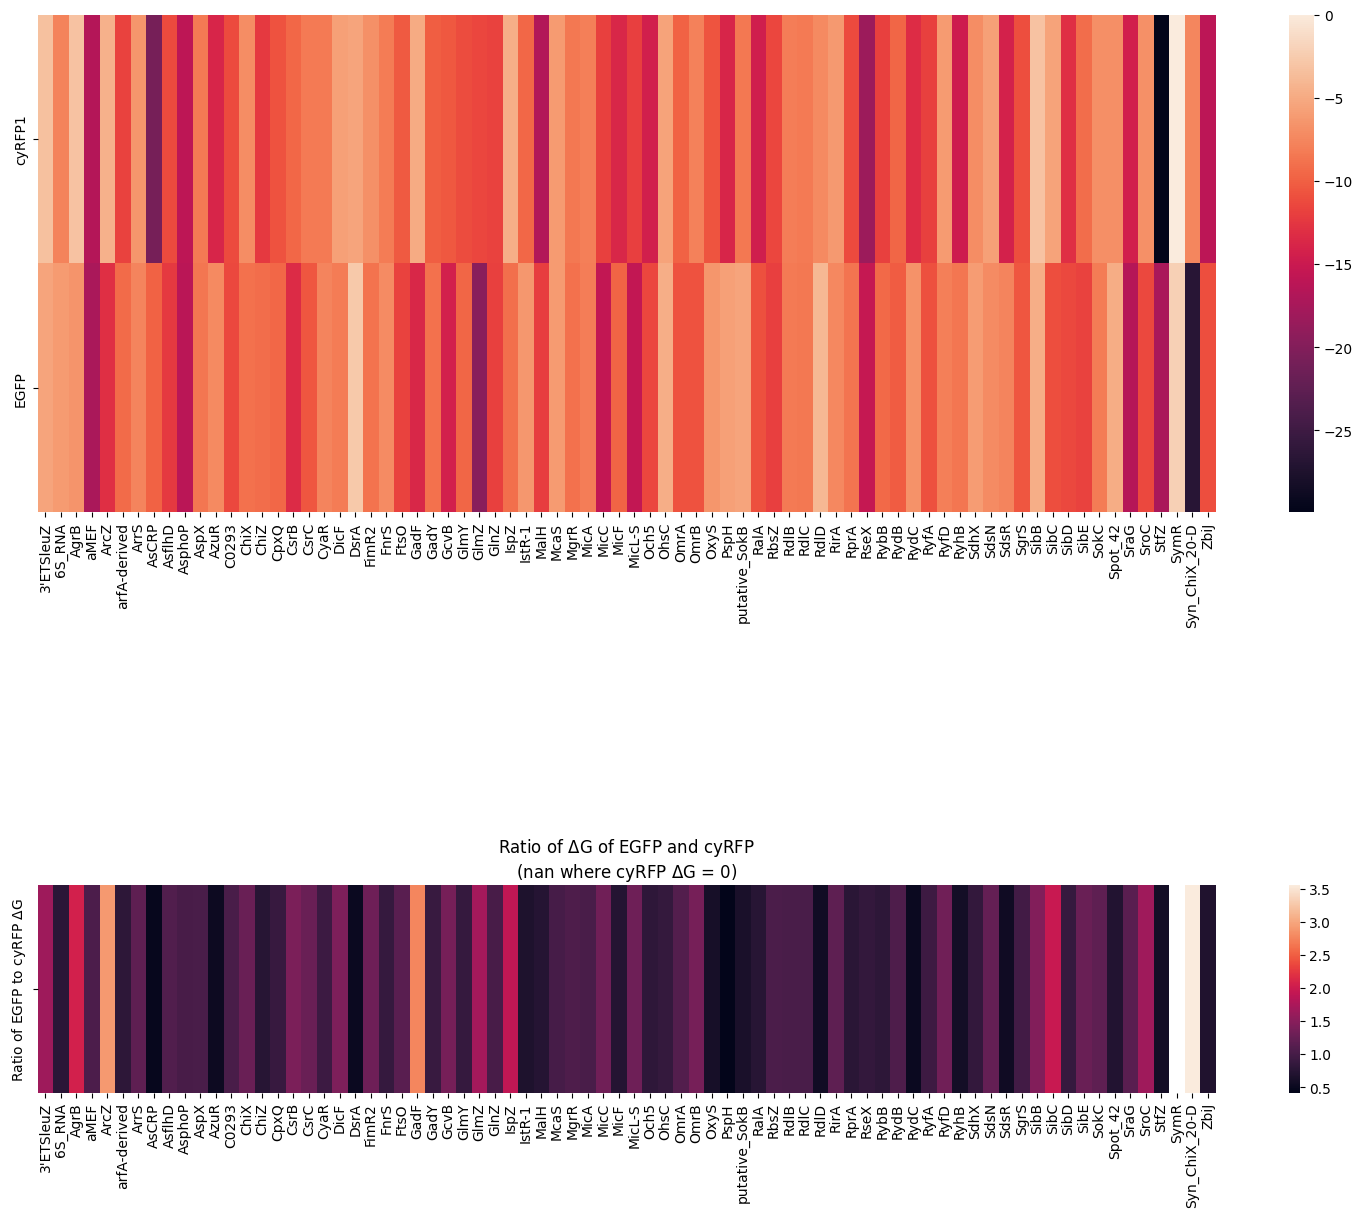

In [21]:
energies = pd.DataFrame(data=np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l.values()]).T,
                        columns=sim_data_l.keys(), index=list(list(sim_data_l.values())[0].keys()))
energies = energies.sort_index(key=lambda x: x.str.lower())[sorted(energies.columns, key=lambda x: x.lower())]

fig = plt.figure(figsize=(19, 2*7))
fig.subplots_adjust(hspace=0.4)
# ax = plt.subplot(2,1,1)
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((4, 1), (3, 0))
sns.heatmap(energies, ax=ax1)
plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')

# ax = plt.subplot(2,1,2)
d = energies.loc['EGFP'] / energies.loc['cyRFP1']
sns.heatmap(np.where(d.to_numpy() < -300, np.nan, d.to_numpy())[None, :], yticklabels=['Ratio of EGFP to cyRFP $\Delta$G'], xticklabels=d.index.to_list(), 
            ax=ax2)
plt.title('Ratio of $\Delta$G of EGFP and cyRFP\n(nan where cyRFP $\Delta$G = 0)')

# energies = energies.drop(labels='MicC')
# ax = plt.subplot(2,1,2)
# sns.heatmap(energies)
# plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)\n(without construct MicC)')

## Fluorescent proteins vs. sRNA interference

Text(0.5, 1.0, 'Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)\ndifference to SynChiX')

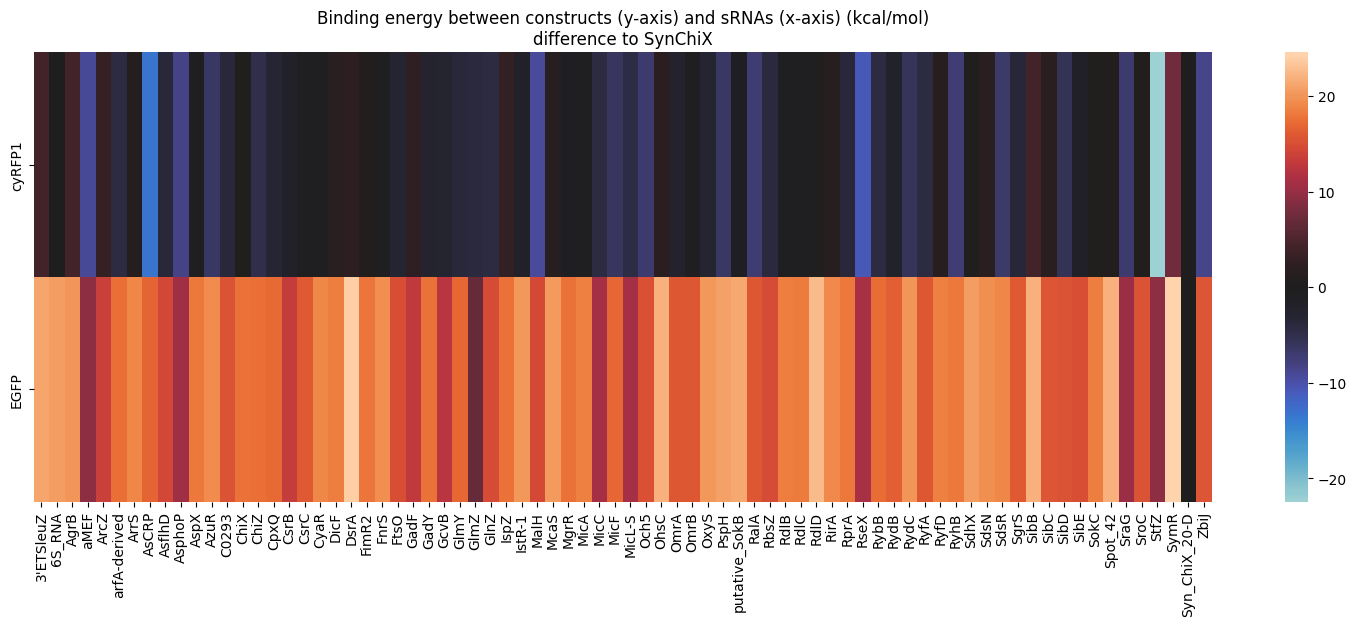

In [43]:
# energies = pd.DataFrame(data=np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l.values()]).T,
#                         columns=sim_data_l.keys(), index=list(list(sim_data_l.values())[0].keys()))
# energies = energies.sort_index(key=lambda x: x.str.lower())[sorted(energies.columns, key=lambda x: x.lower())]

fig = plt.figure(figsize=(19, 2*7))
fig.subplots_adjust(hspace=0.4)

# ax = plt.subplot(2,1,1)
# sns.heatmap(energies)
# plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')

energies.loc['cyRFP1'] = energies.loc['cyRFP1'] - energies.loc['cyRFP1']['Syn_ChiX_20-D']
energies.loc['EGFP'] = energies.loc['EGFP'] - energies.loc['EGFP']['Syn_ChiX_20-D']
ax = plt.subplot(2,1,1)
sns.heatmap(energies, center=0)
plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)\ndifference to SynChiX')

In [42]:
energies.loc['cyRFP1'][energies.loc['cyRFP1'] < -8]

aMEF      -9.10
AsCRP    -13.30
AsphoP    -8.45
MalH      -9.25
RseX     -10.82
StfZ     -22.41
ZbiJ      -8.60
Name: cyRFP1, dtype: float64

In [29]:
# pu1s = pd.DataFrame(data=np.array([[float(vv['seedPu1'].split(':')[0]) if vv['seedPu1'].split(':')[0] else 0 for vv in v.values()] for v in sim_data_l.values()]).T,
#                         columns=sim_data_l.keys(), index=list(list(sim_data_l.values())[0].keys()))
# pu2s = pd.DataFrame(data=np.array([[float(vv['seedPu2'].split(':')[0]) if vv['seedPu2'].split(':')[0] else 0 for vv in v.values()] for v in sim_data_l.values()]).T,
#                         columns=sim_data_l.keys(), index=list(list(sim_data_l.values())[0].keys()))
# pu1s = pu1s.sort_index()[sorted(pu1s.columns)]
# pu2s = pu2s.sort_index()[sorted(pu2s.columns)]

# fig = plt.figure(figsize=(19, 3*8))

# ax = plt.subplot(3,1,1)
# sns.heatmap(pu1s)
# plt.title('Seed probability of sRNA between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')
# ax = plt.subplot(3,1,2)
# sns.heatmap(pu2s)
# plt.title('Seed probability of constructs between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')
# ax = plt.subplot(3,1,3)
# sns.heatmap(pu1s/pu2s )
# plt.title('Seed probability ratio of constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')

## Plot mutations

Text(0.5, 1.0, 'Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')

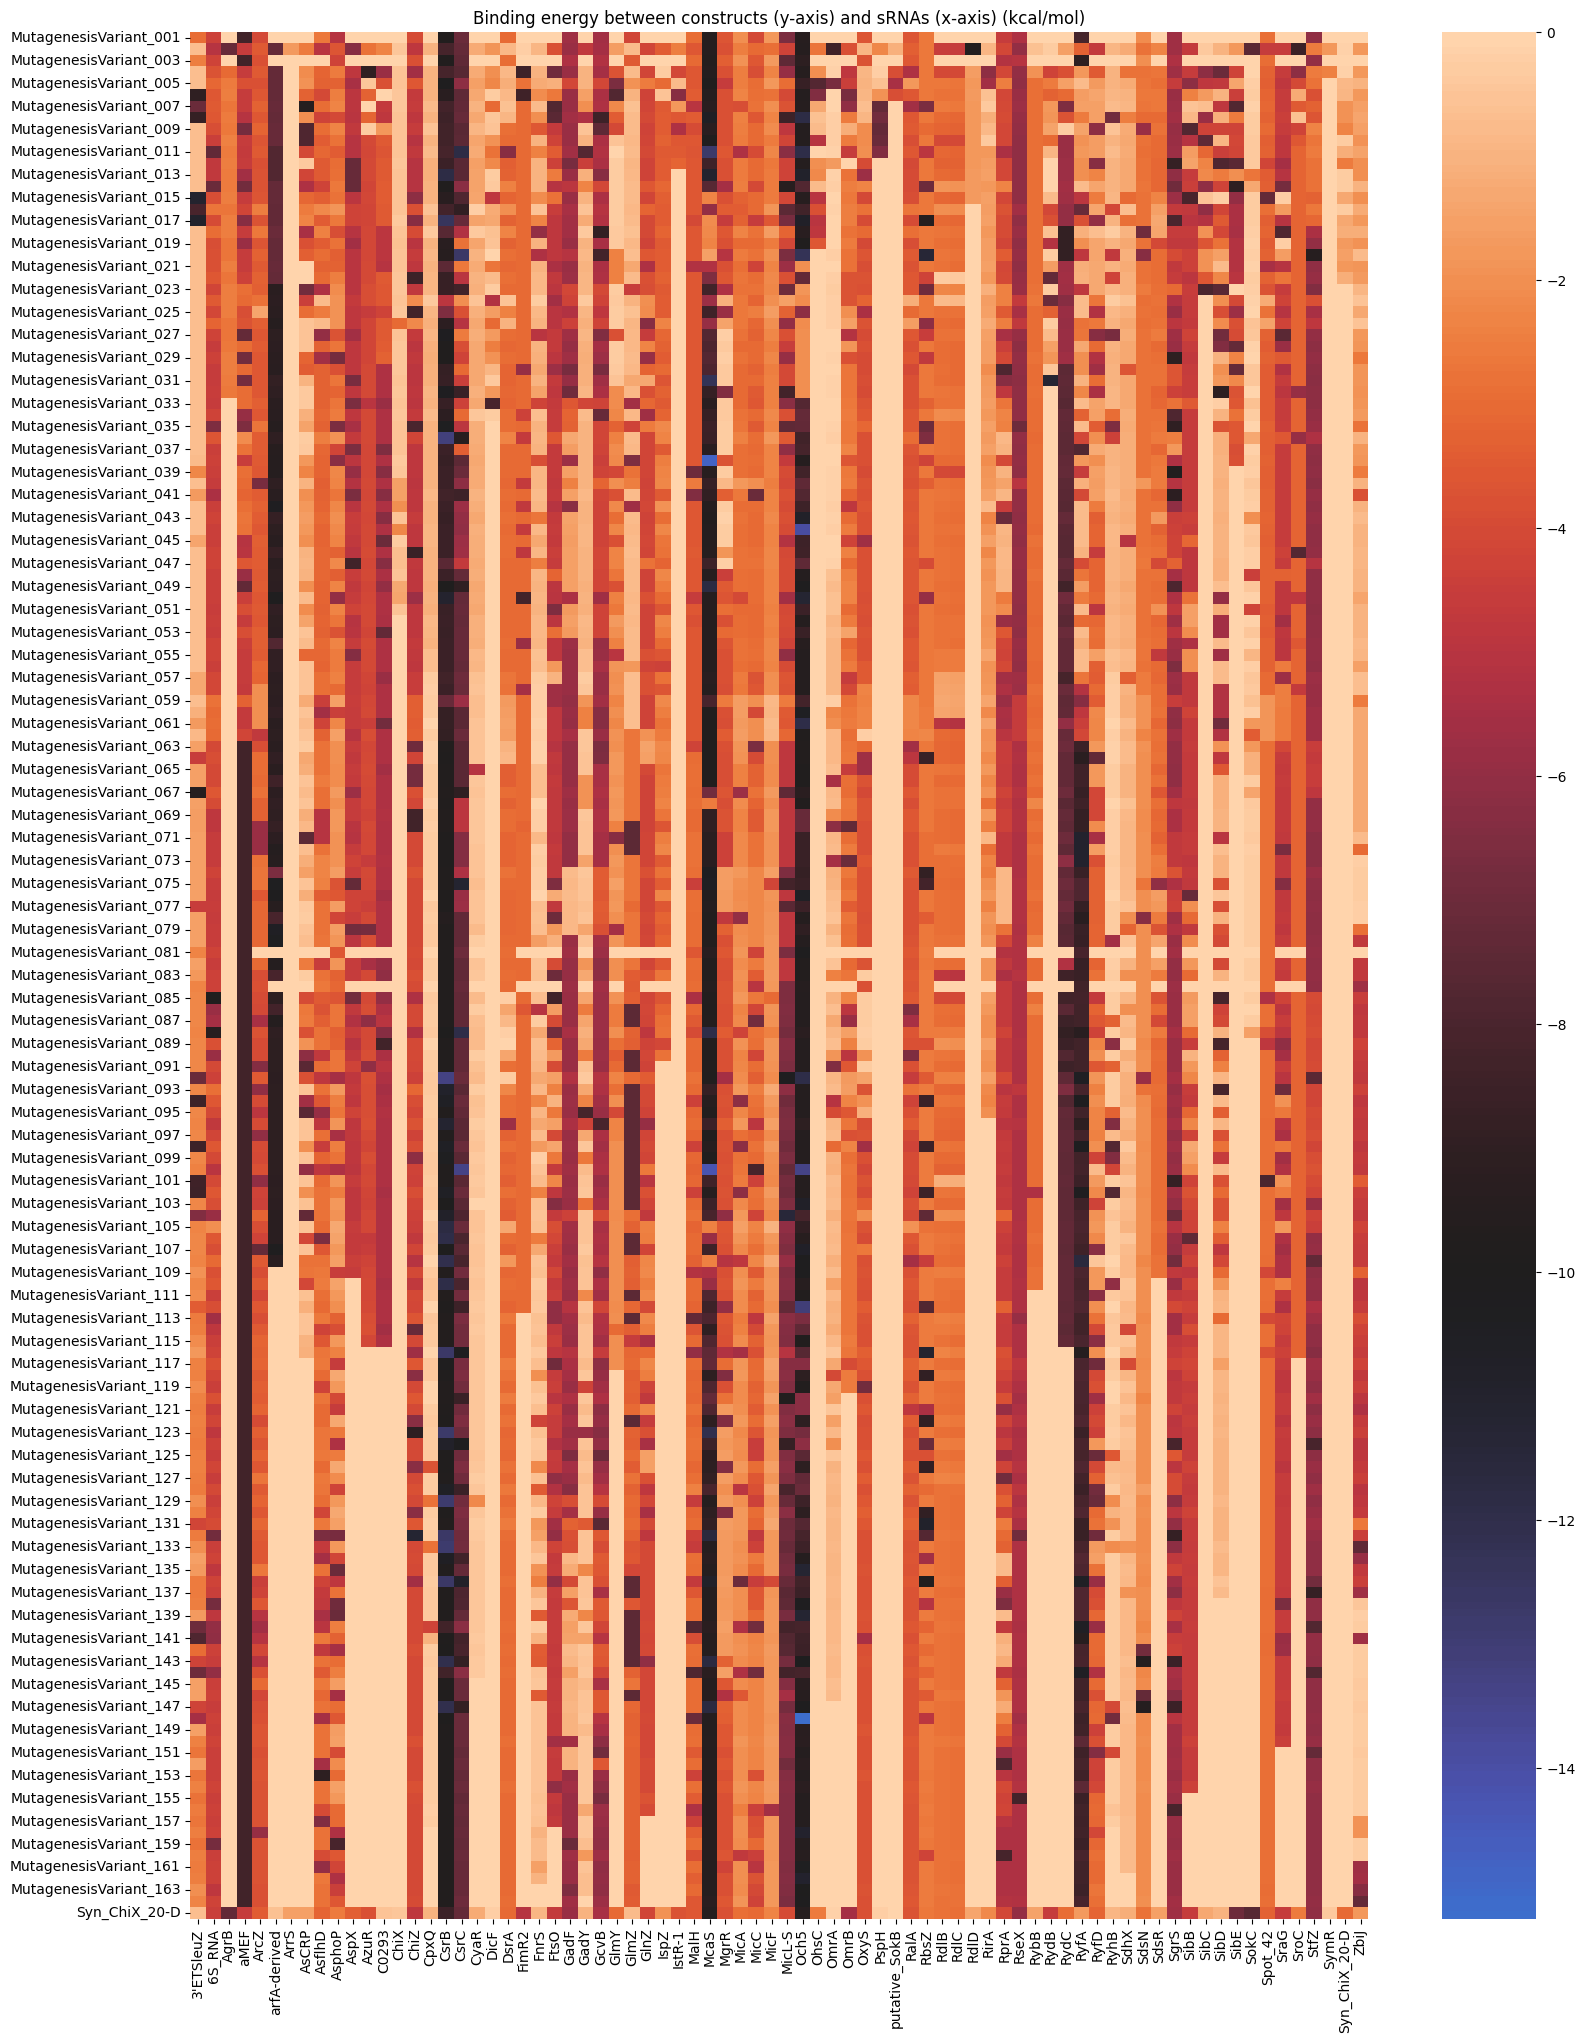

In [80]:
energies = pd.DataFrame(data=np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l_muts.values()]).T,
                        columns=sim_data_l_muts.keys(), index=list(list(sim_data_l_muts.values())[0].keys()))
energies.index = list(map(lambda x: '_'.join([x.split('_')[0], x.split('_')[1].zfill(3)]) if 'Syn' not in x else x, energies.index.to_list()))
energies = energies.sort_index()[sorted(energies.columns, key=lambda x: x.lower())]

fig = plt.figure(figsize=(19, 3.5*7))
fig.subplots_adjust(hspace=0.4)
sns.heatmap(energies, center =-10) 
plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')


## Genome interference

In [26]:
energies = pd.DataFrame(data=np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l_geno.values()]),
                        index=sim_data_l_geno.keys(), columns=list(list(sim_data_l_geno.values())[0].keys()))
energies = energies.sort_index(key=lambda x: x.str.lower())[sorted(energies.columns, key=lambda x: x.lower())]


Text(0.5, 1.0, 'Binding energy between transcription units\nof DH10B vs. constructs (x-axis)')

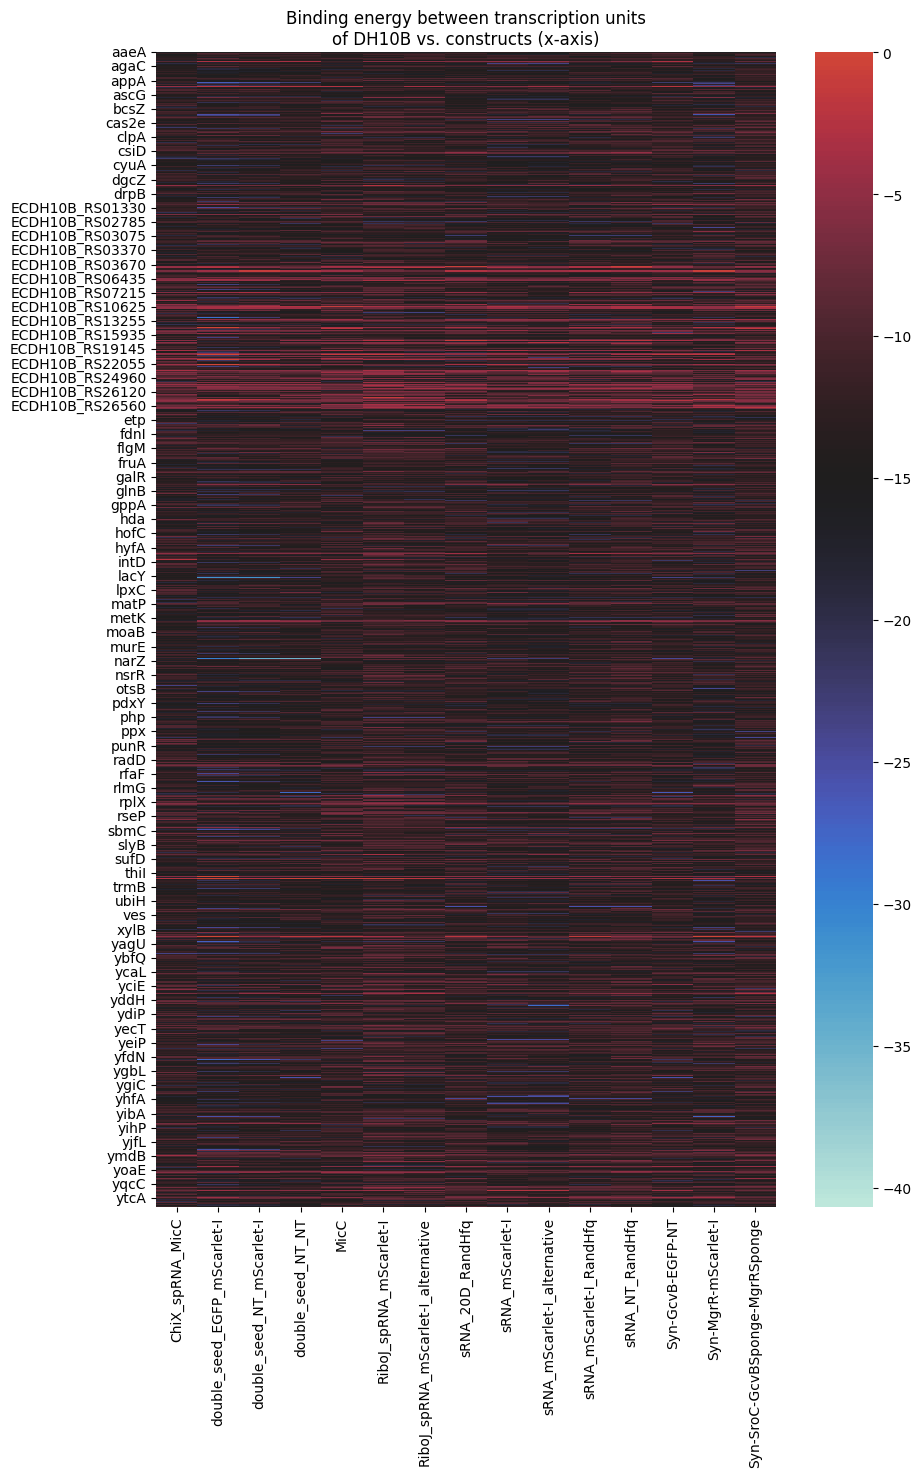

In [28]:
fig = plt.figure(figsize=(10, 15))
sns.heatmap(energies, center=-15)
plt.title('Binding energy between transcription units\nof DH10B vs. constructs (x-axis)')


In [35]:
summary = {}
for c in energies.columns: 
    summary[c] = energies[c][energies[c] < -30].to_dict()
    
summary

{'ChiX_spRNA_MicC': {},
 'double_seed_EGFP_mScarlet-I': {'dcp': -30.39,
  'gsiA': -40.69,
  'ldcC': -31.74,
  'narG': -30.04,
  'nudF': -30.05,
  'rpnC': -33.05,
  'yfjQ': -30.83,
  'yqeF': -31.87},
 'double_seed_NT_mScarlet-I': {'gsiA': -35.95,
  'ldcC': -31.73,
  'narG': -34.58,
  'yqeF': -30.16},
 'double_seed_NT_NT': {'narG': -35.14},
 'MicC': {},
 'RiboJ_spRNA_mScarlet-I': {},
 'RiboJ_spRNA_mScarlet-I_alternative': {},
 'sRNA_20D_RandHfq': {},
 'sRNA_mScarlet-I': {'rpoA': -31.27},
 'sRNA_mScarlet-I_alternative': {'rpoA': -31.27},
 'sRNA_mScarlet-I_RandHfq': {},
 'sRNA_NT_RandHfq': {},
 'Syn-GcvB-EGFP-NT': {'rpnC': -32.01},
 'Syn-MgrR-mScarlet-I': {'gsiA': -31.42},
 'Syn-SroC-GcvBSponge-MgrRSponge': {}}

In [34]:
fn_report = 'data/16_orthogonality_synthetics/mrna_crosstalk_summary.json'
summary = {}
for c in energies.columns: 
    summary[c] = energies[c][energies[c] < -20].to_dict()
    
from synbio_morpher.utils.data.data_format_tools.common import write_json

write_json(data=summary, out_path=fn_report, overwrite=True)